## Review Work
#### Question: 
Q: Why is TIMB horrible for KNN but does so well for the GP, e.g. on ESM-1b? 

In [1]:
import sys
import os
import numpy as np
import random
from scipy.stats import multivariate_normal, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from gpflow.kernels import SquaredExponential, Linear, Matern52

sys.path.insert(0, '..')
# prepare data
from data import load_dataset
from data.train_test_split import RandomSplitter
from util.preprocess import scale_observations
from algorithms.gp_on_real_space import GPonRealSpace
from algorithms.KNN import KNN

2023-05-12 15:39:54.593923: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 15:39:57.077592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
data = "TIMB"
rep = "esm"

_X, _Y = load_dataset(data, representation=rep)
train_idx, _ , test_idx = RandomSplitter(data).split(_X)

# on first split
X, Y = _X[train_idx[0]], _Y[train_idx[0]]
X_test, Y_test = _X[test_idx[0]], _Y[test_idx[0]]

# scale
mean_y, std_y, scaled_y = scale_observations(Y.copy())

FileNotFoundError: [Errno 2] No such file or directory: '/nfs/home/pmg/projects/protein_regression/data/files/timb_seq_reps_n_phyla.pkl'

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


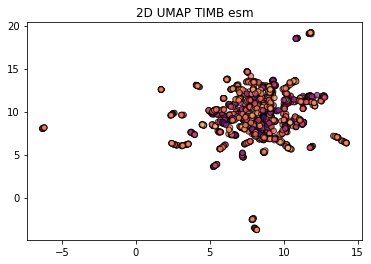

In [3]:
from make_plot_representations import plot_reduced_representations

plot_reduced_representations(data, rep)

### Fitted KNN

In [4]:
method_knn = KNN(optimize=True)
method_knn.train(X, scaled_y)

Score: 0.8465005455434795
Parameters: k=432


In [5]:
_mu_knn_train, _var_knn_train = method_knn.predict_f(X)

y_pred_knn_train = _mu_knn_train*std_y + mean_y
var_knn_train = _var_knn_train*std_y

_mu_knn_test, _var_knn_test = method_knn.predict_f(X_test)

y_pred_knn_test = _mu_knn_test*std_y + mean_y
var_knn_test = _var_knn_test * std_y

### Fitted GP

In [6]:
# GP for TIMB on RandomSplitter, fitted values: l_var = 0.23, len=0.2
# NOTE: we take the already optimized parameters here
method = GPonRealSpace(kernel_factory=lambda: Matern52(variance=0.23, lengthscales=0.2), optimize=False)
method.train(X, scaled_y)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-14 10:40:06.425737: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-14 10:40:06.425875: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
_mu, _var = method.predict(X) # NOTE: include data-noise for KNN comparison, for only model noise use predict_f

y_pred = _mu*std_y + mean_y
var = _var*std_y

In [8]:
_mu_test, _var_test = method.predict(X_test)

y_pred_test = _mu_test*std_y + mean_y
var_test = _var_test*std_y

In [9]:
_mu.shape, _var.shape

(TensorShape([1367, 1]), TensorShape([1367, 1]))

/Users/rcml/miniforge3/envs/env_tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rcml/miniforge3/envs/env_tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/rcml/miniforge3/envs/env_tf/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error o

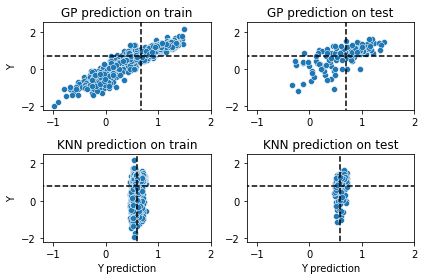

In [10]:
y_lim = (-2.2, 2.5)
x_lim = (-1.2, 2.)
fig, ax = plt.subplots(2,2)
sns.scatterplot(y_pred.numpy().flatten(), Y.flatten(), ax=ax[0,0])
sns.scatterplot(y_pred_test.numpy().flatten(), Y_test.flatten(), ax=ax[0,1])
sns.scatterplot(y_pred_knn_train.flatten(), Y.flatten(), ax=ax[1,0])
sns.scatterplot(y_pred_knn_test.flatten(), Y_test.flatten(), ax=ax[1,1])
ax[0,0].set_title("GP prediction on train")
ax[0,0].set_ylabel("Y")
ax[1,0].set_xlabel("Y prediction")
ax[0,1].set_title("GP prediction on test")
ax[1,0].set_title("KNN prediction on train")
ax[1,0].set_ylabel("Y")
ax[1,1].set_xlabel("Y prediction")
ax[1,1].set_title("KNN prediction on test")
ax[0,0].set_ylim(y_lim)
ax[1,0].set_ylim(y_lim)
ax[0,1].set_ylim(y_lim)
ax[1,1].set_ylim(y_lim)
ax[0,0].set_xlim(x_lim)
ax[1,0].set_xlim(x_lim)
ax[0,1].set_xlim(x_lim)
ax[1,1].set_xlim(x_lim)
ax[0,0].axvline(np.mean(y_pred.numpy().flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[0,1].axvline(np.mean(y_pred_test.numpy().flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[1,0].axvline(np.mean(y_pred_knn_train.flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[1,1].axvline(np.mean(y_pred_knn_test.flatten()), y_lim[0], y_lim[1], c="k", linestyle="--")
ax[0,0].axhline(np.mean(Y.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
ax[0,1].axhline(np.mean(Y.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
ax[1,0].axhline(np.mean(Y_test.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
ax[1,1].axhline(np.mean(Y_test.flatten()), x_lim[0], x_lim[1], c="k", linestyle="--")
plt.tight_layout()
plt.show()

Text(0.5, 0.98, 'Predictive variances (test) \n (GP data noise included)')

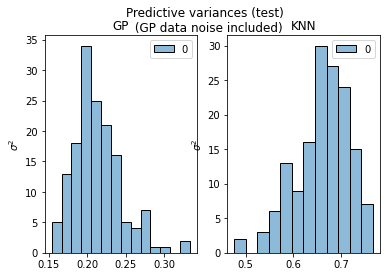

In [11]:
fig, ax = plt.subplots(1, 2)
sns.histplot(var_test, ax=ax[0])
sns.histplot(var_knn_test, ax=ax[1])
ax[0].set_title("GP")
ax[1].set_title("KNN")
ax[0].set_ylabel(r"$\sigma^2$")
ax[1].set_ylabel(r"$\sigma^2$")
plt.suptitle("Predictive variances (test) \n (GP data noise included)")

In [12]:
mvn_train = multivariate_normal(mean=y_pred.numpy().flatten(), cov=var.numpy().flatten())
mvn_test = multivariate_normal(mean=y_pred_test.numpy().flatten(), cov=var_test.numpy().flatten())
# draw from training

In [13]:
mvn_knn_train = multivariate_normal(mean=y_pred_knn_train.flatten(), cov=var_knn_train.flatten())
mvn_knn_test = multivariate_normal(mean=y_pred_knn_test.flatten(), cov=var_knn_test.flatten())

In [18]:
d_train_samples = mvn_train.rvs(size=5)
d_test_samples = mvn_test.rvs(size=5)
d_train_knn_samples = mvn_knn_train.rvs(size=5)
d_test_knn_samples = mvn_knn_test.rvs(size=5)

Text(0.5, 0.98, 'Distribution Samples')

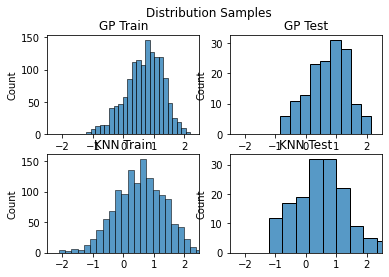

In [17]:
xlim=(-2.5, 2.5)
fig, ax = plt.subplots(2, 2)
sns.histplot(d_train_samples.flatten(), ax=ax[0,0])
sns.histplot(d_test_samples.flatten(), ax=ax[0,1])
sns.histplot(d_train_knn_samples.flatten(), ax=ax[1,0])
sns.histplot(d_test_knn_samples.flatten(), ax=ax[1,1])
ax[0,0].set_title("GP Train")
ax[0,0].set_xlim(xlim)
ax[0,1].set_xlim(xlim)
ax[1,0].set_xlim(xlim)
ax[1,1].set_xlim(xlim)
ax[0,1].set_title("GP Test")
ax[1,0].set_title("KNN Train")
ax[1,1].set_title("KNN Test")
plt.suptitle("Distribution Samples")

## Section Predictive Uncertainties
### and Extrapolation

Q: Can we add multiple mutations at random and rank by predictive uncertainties?

In [9]:
dataset = "1FQG"
N_mutants = 200
N_splits = 3

In [28]:
from data.load_dataset import load_one_hot
from data import load_dataset, get_alphabet
from util import numpy_one_hot_2dmat
from algorithm_factories import ALGORITHM_REGISTRY
from algorithm_factories import KNNFactory, UncertainRFFactory, GPMaternFactory, GPLinearFactory
import seaborn as sns
import pandas as pd
import random

X_seq, _ = load_one_hot(dataset) # obtain original sequence

X_mutated = {}
# add mutations to X
for m_count in [2, 3, 4]:
    X_mutated[m_count] = []
    for _ in range(N_mutants): # make 1000 substitutions
        _X = X_seq[0].copy() # copy WT for mutation
        pos = random.sample(range(X_seq.shape[1]), m_count) # select positions, no duplicates
        aa = np.random.randint(0, 20, size=m_count) # select AA for substitutions, w/ duplicates
        while any([a==x for a,x in zip(aa, _X[pos])]):
            aa = np.random.randint(0, len(get_alphabet(dataset)), size=m_count) # redraw if same AA
        _X[pos] = aa
        assert sum(x!=y for x, y in zip(_X, X_seq[0])) == m_count # test that dist to WT is mutation count
        # one-hot encode mutated X
        X_mutated[m_count].append(_X)
    # one-hot encode and normalize by seq length
    X_mutated[m_count] = numpy_one_hot_2dmat(np.vstack(X_mutated[m_count]), max=len(get_alphabet(dataset)))

In [29]:
# Extract sequences from one-hot encodings
inverse_alphabet = {v: k for k, v in get_alphabet(dataset).items()}
sequences_dict = {}
for m_count in [2, 3, 4]:
    _x = X_mutated[m_count]
    # Tokenize
    _x = _x.reshape(_x.shape[0], -1, 24).argmax(axis=-1)
    sequences = []
    for i in range(_x.shape[0]):
        # Tokens to strings
        sequences.append("".join([inverse_alphabet[i] for i in _x[i]]))
    sequences_dict[m_count] = sequences

In [30]:
import torch
from esm import Alphabet, FastaBatchedDataset, pretrained
assert torch.cuda.device_count() == 1

In [31]:
# Code adapted from https://github.com/facebookresearch/esm/blob/main/scripts/extract.py 
ESM_PATH = "models/esm1b_t33_650M_UR50S.pt"
model, alphabet = pretrained.load_model_and_alphabet(ESM_PATH)
model.eval()
truncation_seq_length = 1022
toks_per_batch = 4096
if torch.cuda.is_available():
    model = model.cuda()
    print("Transferred model to GPU")

Transferred model to GPU


In [32]:
# Overwrite one_hot X_mutated with ESM embeddings
X_mutated = {}
for m_count in [2, 3, 4]:
    # Twin lists of sequences and labels
    sequence_strs = sequences_dict[m_count]
    sequence_labels = "nan" * N_mutants
    esm_dataset = FastaBatchedDataset(sequence_labels=sequence_labels, sequence_strs=sequence_strs)
    batches = esm_dataset.get_batch_indices(toks_per_batch, extra_toks_per_seq=1)
    data_loader = torch.utils.data.DataLoader(
        esm_dataset, collate_fn=alphabet.get_batch_converter(truncation_seq_length), batch_sampler=batches
    )
    repr_layers = [(i + model.num_layers + 1) % (model.num_layers + 1) for i in [-1]]

    # Suboptimal: append new embeddings
    X_esm = torch.zeros((0, 1280))
    with torch.no_grad():
        for batch_idx, (_, strs, toks) in enumerate(data_loader):
            if torch.cuda.is_available():
                toks = toks.to(device="cuda", non_blocking=True)
            out = model(toks, repr_layers=repr_layers, return_contacts=False)
            representations = {
                layer: t.to(device="cpu") for layer, t in out["representations"].items()
            }
            for i in range(len(strs)):
                esm_mean = {
                        layer: t[i, 1 : len(strs[i]) + 1].mean(0).clone()
                        for layer, t in representations.items()
                    }[repr_layers[0]]  # repr_layers[0] = 33 for ESM-1b
                # Append mean-pooled embedding
                X_esm = torch.cat((X_esm, esm_mean.unsqueeze(0)))
    X_esm = X_esm.cpu().numpy()
    X_mutated[m_count] = X_esm


Method: KNN
Training...
Score: 0.6965505640994198
Parameters: k=5
Predicting...
Split=0: r=0.8070421083850928, NMSE=0.34700240455656484
Pred.Var. Sorted Variants: [0.315, 0.665, 1.0]; 
 first & last 3 values=[[8.51006999e-05 1.85838517e-04 1.88248820e-04 2.04590897e-04
 2.48330614e-04 4.34731500e-04 4.73307325e-04 5.32064610e-04
 5.56130129e-04 7.17539322e-04 7.23731452e-04 7.36993800e-04
 7.91655636e-04 8.31373727e-04 8.92600437e-04 1.02315765e-03
 1.08126757e-03 1.17690879e-03 1.31464366e-03 1.48720275e-03
 1.49680146e-03 1.56575960e-03 1.64205280e-03 1.65814553e-03
 1.66713088e-03 1.92186706e-03 1.97030063e-03 2.04075885e-03
 2.16520718e-03 2.41878594e-03 2.41884608e-03 2.44825595e-03
 2.77731739e-03 3.17893825e-03 3.42473013e-03 3.46883984e-03
 3.69171956e-03 3.86004526e-03 3.89836675e-03 4.26476668e-03
 4.41709708e-03 4.82971220e-03 4.83595895e-03 5.71590424e-03
 6.82337924e-03 7.49868814e-03 7.60991144e-03 8.50789229e-03
 8.51786291e-03 9.13191628e-03 9.38919779e-03 9.69005877e-0

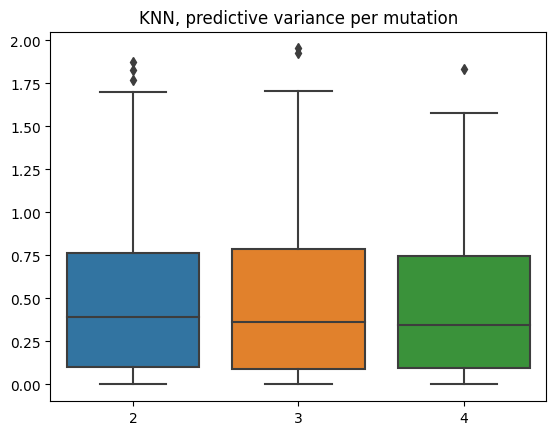

Training...
Score: 0.6983101534815658
Parameters: k=6
Predicting...
Split=1: r=0.8091742089488926, NMSE=0.34462308261781005
Pred.Var. Sorted Variants: [0.28, 0.68, 1.0]; 
 first & last 3 values=[[3.81951398e-04 3.89595771e-04 5.12985861e-04 5.17950967e-04
 5.46165618e-04 5.61818866e-04 6.04965009e-04 7.27882884e-04
 8.40754714e-04 1.01306857e-03 1.05091936e-03 1.09669270e-03
 1.26391642e-03 1.26597559e-03 1.37658708e-03 1.63136314e-03
 1.86212773e-03 1.99342551e-03 2.37765695e-03 2.37771183e-03
 2.44105834e-03 2.54699310e-03 2.89728701e-03 3.09401338e-03
 3.21861623e-03 3.32309009e-03 3.35697181e-03 3.47350627e-03
 4.02609109e-03 4.65332140e-03 4.70206914e-03 4.78000633e-03
 6.48225268e-03 7.88533783e-03 9.05987933e-03 9.35275688e-03
 9.50707953e-03 9.72353641e-03 9.89314778e-03 1.00111223e-02
 1.09958791e-02 1.39088507e-02 1.51802157e-02 1.52250196e-02
 1.79230030e-02 2.10070819e-02 2.15371588e-02 2.16254629e-02
 2.21452492e-02 2.27197195e-02 2.56253250e-02 2.58395288e-02
 2.74976979e

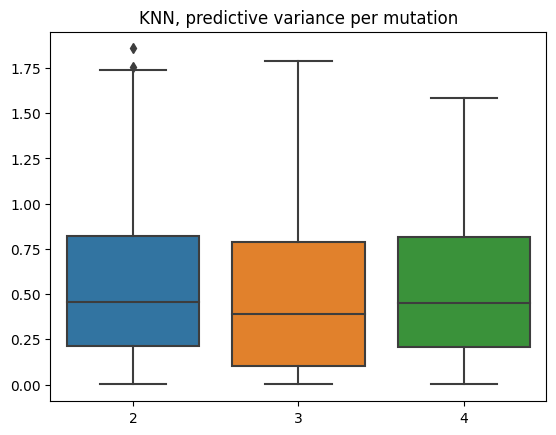

Training...
Score: 0.6952858274486605
Parameters: k=5
Predicting...
Split=2: r=0.8344530561665056, NMSE=0.2991229620150746
Pred.Var. Sorted Variants: [0.325, 0.625, 1.0]; 
 first & last 3 values=[[1.77523573e-04 1.88342261e-04 2.04692449e-04 2.48453878e-04
 3.72610887e-04 4.10551233e-04 4.34947287e-04 4.60153728e-04
 4.73542260e-04 4.77723319e-04 6.55851288e-04 6.69306793e-04
 6.94097400e-04 8.31786395e-04 1.08180427e-03 1.17749297e-03
 1.28607285e-03 1.34915779e-03 1.41746775e-03 1.46119707e-03
 1.51472847e-03 1.64286786e-03 1.81512084e-03 1.81711155e-03
 1.83772249e-03 2.36079765e-03 2.36901107e-03 2.42004672e-03
 2.47983704e-03 2.90646949e-03 2.92183107e-03 3.00707722e-03
 3.42643006e-03 3.69355202e-03 3.86196127e-03 4.41928958e-03
 4.83835937e-03 5.01325582e-03 5.02905527e-03 5.41314585e-03
 5.71874144e-03 6.38978250e-03 7.35072382e-03 7.50241026e-03
 7.70699261e-03 8.19695409e-03 8.51211534e-03 9.00186112e-03
 9.17174100e-03 9.80907422e-03 1.03720801e-02 1.06503649e-02
 1.06563819

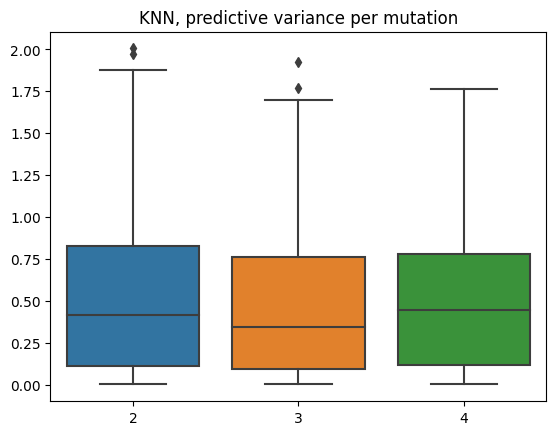

Method: GPmatern52
Training...
Predicting...


/nfs/home/pmg/projects/protein_regression/algorithms/gp_on_real_space.py:84: UserWarning: The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...
  warnings.warn("The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...")


Split=0: r=0.7476331225268822, NMSE=0.8325244552232327
Pred.Var. Sorted Variants: [0.69, 0.72, 1.0]; 
 first & last 3 values=[[0.69345061 0.69345212 0.69345229 0.69345342 0.69345342 0.69345345
 0.69345346 0.69345348 0.69345348 0.69345352 0.69345354 0.6934536
 0.69345361 0.69345362 0.69345363 0.69345363 0.69345364 0.69345365
 0.69345367 0.69345367 0.69345367 0.69345368 0.69345368 0.69345368
 0.69345369 0.69345369 0.69345369 0.69345369 0.69345369 0.69345369
 0.6934537  0.6934537  0.6934537  0.6934537  0.6934537  0.6934537
 0.69345371 0.69345371 0.69345371 0.69345371 0.69345371 0.69345371
 0.69345372 0.69345372 0.69345372 0.69345372 0.69345372 0.69345372
 0.69345372 0.69345372 0.69345372 0.69345372 0.69345372 0.69345372
 0.69345372 0.69345372 0.69345372 0.69345373 0.69345373 0.69345373
 0.69345373 0.69345373 0.69345373 0.69345373 0.69345373 0.69345373
 0.69345373 0.69345373 0.69345373 0.69345373 0.69345373 0.69345373
 0.69345373 0.69345373 0.69345373 0.69345373 0.69345374 0.69345374
 0.69

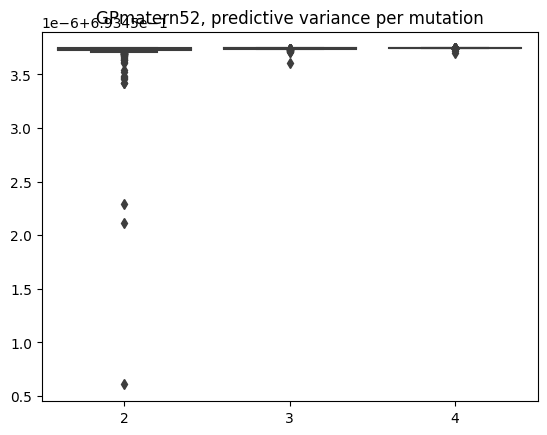

Training...
Predicting...
Split=1: r=0.7598341646212035, NMSE=0.8092857131103082


/nfs/home/pmg/projects/protein_regression/algorithms/gp_on_real_space.py:84: UserWarning: The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...
  warnings.warn("The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...")


Pred.Var. Sorted Variants: [0.685, 0.72, 1.0]; 
 first & last 3 values=[[0.6922088  0.6922106  0.69221082 0.6922116  0.69221163 0.69221164
 0.69221166 0.6922117  0.69221172 0.69221174 0.6922118  0.69221181
 0.69221182 0.69221183 0.69221183 0.69221184 0.69221186 0.69221186
 0.69221187 0.69221187 0.69221187 0.69221188 0.69221188 0.69221188
 0.69221189 0.69221189 0.69221189 0.69221189 0.69221189 0.69221189
 0.6922119  0.6922119  0.6922119  0.6922119  0.6922119  0.6922119
 0.69221191 0.69221191 0.69221191 0.69221191 0.69221191 0.69221191
 0.69221191 0.69221192 0.69221192 0.69221192 0.69221192 0.69221192
 0.69221192 0.69221192 0.69221192 0.69221192 0.69221192 0.69221192
 0.69221192 0.69221192 0.69221193 0.69221193 0.69221193 0.69221193
 0.69221193 0.69221193 0.69221193 0.69221193 0.69221193 0.69221193
 0.69221193 0.69221193 0.69221193 0.69221193 0.69221193 0.69221193
 0.69221193 0.69221193 0.69221193 0.69221193 0.69221193 0.69221193
 0.69221193 0.69221193 0.69221193 0.69221193 0.69221193 0.

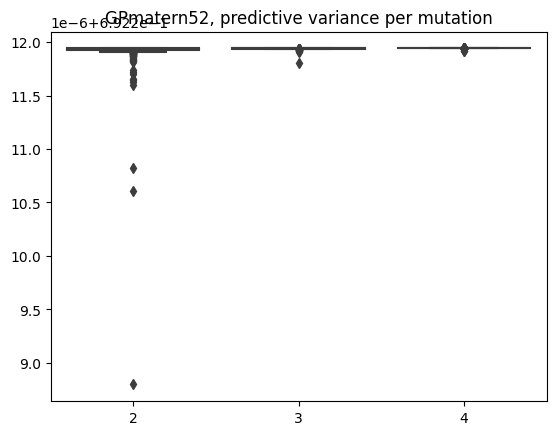

Training...
Predicting...
Split=2: r=0.7612265354076223, NMSE=0.818804792263272


/nfs/home/pmg/projects/protein_regression/algorithms/gp_on_real_space.py:84: UserWarning: The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...
  warnings.warn("The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...")


Pred.Var. Sorted Variants: [0.695, 0.725, 1.0]; 
 first & last 3 values=[[0.69310656 0.69310807 0.6931083  0.69310936 0.69310938 0.69310941
 0.69310944 0.69310944 0.69310945 0.69310949 0.69310951 0.69310956
 0.69310956 0.69310958 0.69310959 0.69310959 0.6931096  0.69310962
 0.69310963 0.69310963 0.69310963 0.69310964 0.69310964 0.69310965
 0.69310965 0.69310965 0.69310966 0.69310966 0.69310966 0.69310966
 0.69310966 0.69310966 0.69310966 0.69310966 0.69310966 0.69310966
 0.69310967 0.69310967 0.69310967 0.69310967 0.69310967 0.69310967
 0.69310968 0.69310968 0.69310968 0.69310968 0.69310968 0.69310968
 0.69310968 0.69310968 0.69310968 0.69310968 0.69310969 0.69310969
 0.69310969 0.69310969 0.69310969 0.69310969 0.69310969 0.69310969
 0.69310969 0.69310969 0.69310969 0.69310969 0.69310969 0.69310969
 0.69310969 0.69310969 0.69310969 0.69310969 0.6931097  0.6931097
 0.6931097  0.6931097  0.6931097  0.6931097  0.6931097  0.6931097
 0.6931097  0.6931097  0.6931097  0.6931097  0.6931097  0.

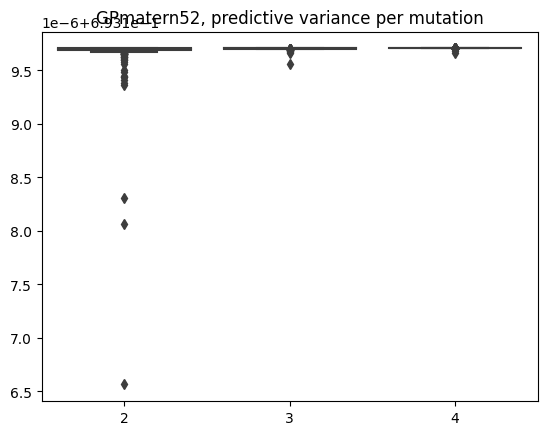

Method: GPlinear
Training...
Predicting...
Split=0: r=0.73958222325102, NMSE=0.5309802132337713


/nfs/home/pmg/projects/protein_regression/algorithms/gp_on_real_space.py:84: UserWarning: The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...
  warnings.warn("The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...")


Pred.Var. Sorted Variants: [0.695, 0.695, 1.0]; 
 first & last 3 values=[[0.23548817 0.23567846 0.2358842  0.23589944 0.2359067  0.23596282
 0.23599492 0.236295   0.23642564 0.23643032 0.23649071 0.23654243
 0.2365693  0.23657391 0.23658046 0.23659099 0.23664239 0.23666603
 0.23670199 0.23671857 0.2367243  0.23672487 0.23673053 0.23673669
 0.23676965 0.23677362 0.23681569 0.23683157 0.23694734 0.23697019
 0.23698369 0.23698457 0.23700058 0.23700411 0.2370225  0.23702374
 0.23703155 0.23707139 0.23708597 0.23711611 0.23712698 0.23713106
 0.23713173 0.23713507 0.23715435 0.23717251 0.23717508 0.23719224
 0.23719333 0.23719727 0.23719956 0.23722778 0.23724355 0.23725033
 0.23727936 0.2373319  0.23736793 0.23738066 0.23738189 0.23738636
 0.23739403 0.23739813 0.23741224 0.23742188 0.23746199 0.23747022
 0.23751252 0.23754448 0.23754856 0.23755905 0.23755944 0.23759189
 0.23760036 0.23760701 0.23761852 0.23766058 0.23766864 0.23767758
 0.23768521 0.23768669 0.23769498 0.23775085 0.23776384 

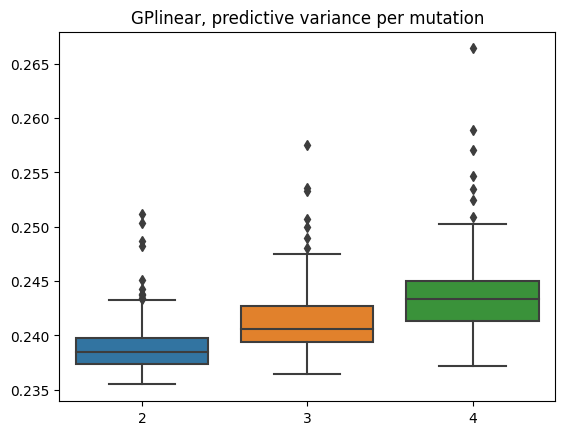

Training...
Predicting...
Split=1: r=0.7380771700107442, NMSE=0.5528689472143576


/nfs/home/pmg/projects/protein_regression/algorithms/gp_on_real_space.py:84: UserWarning: The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...
  warnings.warn("The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...")


Pred.Var. Sorted Variants: [0.69, 0.69, 1.0]; 
 first & last 3 values=[[0.23507347 0.23525461 0.23544495 0.23547059 0.2354959  0.2355185
 0.23555985 0.23586721 0.23597395 0.23599661 0.2360472  0.23611588
 0.23612246 0.23614215 0.23616244 0.23619768 0.23622058 0.23625936
 0.23627944 0.23628042 0.23628065 0.23628223 0.23630041 0.23631966
 0.23633254 0.23634864 0.23636047 0.23637297 0.23645566 0.23650611
 0.23654246 0.23656768 0.23656835 0.23657772 0.23658119 0.23658226
 0.23660161 0.23660746 0.23661845 0.23663893 0.23667554 0.23668238
 0.23670465 0.23671023 0.23672005 0.23674046 0.23674584 0.23674613
 0.23676449 0.23676853 0.23677001 0.23678128 0.23681407 0.2368311
 0.23689215 0.23690471 0.23691959 0.23692186 0.23692692 0.23692746
 0.23693109 0.23698876 0.2369968  0.23702444 0.23702701 0.23706905
 0.23707168 0.23708177 0.23708651 0.23713247 0.23713884 0.23715544
 0.23716146 0.23718486 0.23719488 0.23720059 0.23720763 0.237217
 0.23722463 0.23723264 0.23726178 0.2373243  0.23733074 0.2373

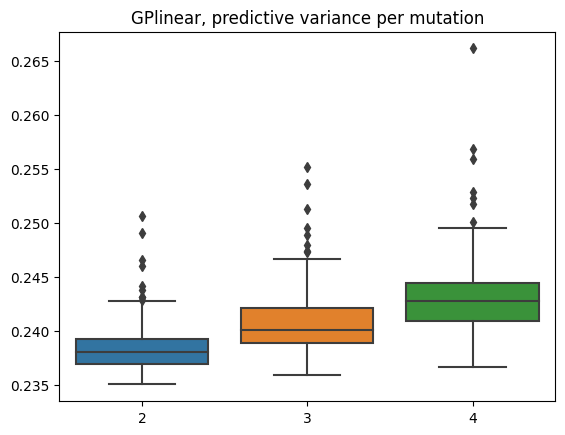

Training...
Predicting...
Split=2: r=0.7448821201771474, NMSE=0.5313379751918681


/nfs/home/pmg/projects/protein_regression/algorithms/gp_on_real_space.py:84: UserWarning: The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...
  warnings.warn("The optimizer tried a numerically unstable parameter configuration. Trying to recover optimization...")


Pred.Var. Sorted Variants: [0.69, 0.695, 1.0]; 
 first & last 3 values=[[0.23540346 0.23554914 0.23576365 0.23576425 0.23577592 0.23582063
 0.23585913 0.23619467 0.23630143 0.23632168 0.23634595 0.23640439
 0.23644768 0.23645007 0.23645494 0.23651097 0.23651864 0.23656195
 0.23657539 0.23659345 0.23660016 0.23660293 0.23660509 0.23662024
 0.23663095 0.23666268 0.23668117 0.23668873 0.23674903 0.2368046
 0.23684822 0.23684941 0.23686628 0.23687085 0.23687998 0.23688247
 0.23689866 0.23691464 0.23691745 0.2369673  0.23697367 0.23698378
 0.23701609 0.23701802 0.2370258  0.23703399 0.23704496 0.23705503
 0.23706202 0.23707011 0.23707294 0.23709557 0.23709862 0.23711858
 0.23714456 0.2372121  0.23722765 0.23724028 0.23724033 0.23725618
 0.23726561 0.23726895 0.23727788 0.2372797  0.23733228 0.23734164
 0.23739275 0.23739329 0.23741093 0.23745045 0.237473   0.23747444
 0.23748006 0.23748266 0.23748699 0.23749865 0.23753387 0.23754106
 0.23755374 0.23756264 0.23757376 0.23762863 0.23763666 0.

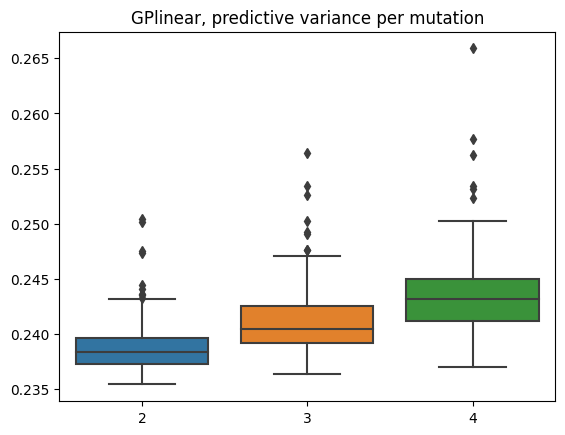

In [33]:
# Training data
X, Y = load_dataset(dataset, representation="esm")
# Randomsplitting
train_indices, _, test_indices = RandomSplitter(dataset).split(X)

# for method_factory in [UncertainRFFactory, KNNFactory, GPMaternFactory, GPLinearFactory, ]:
for method_factory in [KNNFactory, GPMaternFactory, GPLinearFactory]:
    method = method_factory("one_hot", alphabet=get_alphabet(dataset))
    print(f"Method: {method.get_name()}")
    for split in range(N_splits):
        X_train = X[train_indices[split], :]
        Y_train = Y[train_indices[split], :]
        X_test = X[test_indices[split], :]
        Y_test = Y[test_indices[split]]
        # STANDARDIZE OBSERVATIONS ON TRAIN
        mean_y, std_y, scaled_y = scale_observations(Y_train.copy())
        # SET PRIORS IF GP
        if "GP" in method.get_name() and X_train.shape[0] > 1: # set initial parameters based on distance in space if using full latent space
            init_len = np.max(np.abs(np.subtract(X_train[0], X_train[1])))
            eps = 0.001
            method.init_length = init_len if init_len > 0.0 else init_len+eps # if reduced on lower dim this value is too small
        # TRAIN MODEL:
        method.train(X_train, scaled_y)
        # PREDICT:
        _mu, _unc = method.predict_f(X_test)
        # undo scaling
        mu = _mu*std_y + mean_y
        unc = _unc*std_y
        assert(mu.shape[1] == 1 == unc.shape[1])
        assert(mu.shape[0] == unc.shape[0] == len(test_indices[split]))
        # record mean and median smse and nll and spearman correlation
        assert mu.shape == Y_test.shape, "shape mismatch "+str(mu.shape)+' '+str(Y_test.flatten().shape)
        # COMPUTE RESULT METRICS
        baseline = np.mean(np.square(Y_test - np.repeat(mean_y, len(Y_test)).reshape(-1,1)))
        err2 = np.square(Y_test - mu)
        mse = np.mean(err2)/baseline
        r = spearmanr(Y_test, mu)[0]  # we do not care about the p-value
        n = X_train.shape[0]
        print(f"Split={split}: r={r}, NMSE={mse}")

        # Test ranking multivariates
        mv_predictions = {}
        fractions = []
        for m_count in X_mutated.keys():
            _, _unc = method.predict(X_mutated[m_count])
            unc = _unc*std_y
            mv_predictions[m_count] = unc
        all_mv_predictive_variances = np.concatenate([val for val in mv_predictions.values()]).flatten()
        sort_idx = np.argsort(all_mv_predictive_variances)
        fractions = []
        for i, m_count in enumerate(X_mutated.keys()):
            # Test: how many pred.var fall into the respective mutation count interval
            # The higher the mutation count the higher the expected pred. var.
            frac = sum(sort_idx[N_mutants*i:N_mutants*(i+1)] < N_mutants*(i+1)) / N_mutants
            fractions.append(frac)

        print(f"Pred.Var. Sorted Variants: {fractions}; \n first & last 3 values=[{np.sort(np.unique(all_mv_predictive_variances))}]")  

        # visualize via boxplot per mutation
        sns.boxplot(data=pd.DataFrame({k: np.concatenate(v).flatten() for k, v in mv_predictions.items()}))
        plt.title(f"{method.get_name()}, predictive variance per mutation")
        plt.show()